# Digits OCR

Source - https://www.kaggle.com/aakashnain/building-a-captcha-ocr-in-tf2-0/notebook

## Creating Data Structure

In [1]:
!mkdir data
%cd data
!mkdir raw external processed
!mkdir processed/train processed/test

/kaggle/working/data


In [2]:
!apt-get -qq install tree

debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package tree.
(Reading database ... 110556 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...


In [3]:
!tree .

.
├── external
├── processed
│   ├── test
│   └── train
└── raw

5 directories, 0 files


## Downloading Data

In [4]:
!wget -q http://13.234.225.243:9600/train_data.tar -O external/train_data.tar

In [5]:
!wget -q http://13.234.225.243:9600/test_data.tar -O external/test_data.tar 

In [6]:
!tar -xf external/train_data.tar -C raw/

In [7]:
!tar -xf external/test_data.tar -C raw/

In [8]:
!wget -q http://13.234.225.243:9600/train_data.csv -O raw/train_data/train_data.csv

In [9]:
!wget -q http://13.234.225.243:9600/sample_submission.csv -O raw/test_data/sample_submission.csv

## Utility Functions

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [11]:
sns.set_style("darkgrid")

In [12]:
def plot_grid(images, labels=None, h=5, w=5, title=""):
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    random_indexes = random.sample(range(len(images)), k=h*w)
    for i, j in enumerate(random_indexes):
        ax[i // h, i % w].imshow(images[i])
        ax[i // h, i % w].axis("off")
        ax[i // h, i % w].set_title(labels[i], fontdict={"fontsize": 20})
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

In [13]:
def plot_hist(hist):
    plt.figure(figsize=(6, 6))
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

## Extract DateField

In [14]:
from glob import glob

import cv2 as cv
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm


class ExtractRectangle:
    def __init__(self):
        super().__init__()

        self.minLinLength_h = 70
        self.minLinLength_v = 5
        self.maxLineGap = 20
        self.heights = []
        self.widths = []
        self.paths = []

    def is_horizontal(self, line, thresh=5):
        return abs(line[1] - line[3]) <= thresh

    def is_vertical(self, line, thresh=5):
        return abs(line[0] - line[2]) <= thresh

    def get_lines(self, canny, horizontal=True):
        lines = []
        if horizontal:
            linesP = cv.HoughLinesP(
                canny,
                rho=1,
                theta=np.pi / 180,
                threshold=10,
                lines=None,
                minLineLength=self.minLinLength_h,
                maxLineGap=20,
            )
        else:
            linesP = cv.HoughLinesP(
                canny,
                rho=1,
                theta=np.pi / 180,
                threshold=10,
                lines=None,
                minLineLength=self.minLinLength_v,
                maxLineGap=20,
            )
        if linesP is not None:
            for i in range(0, len(linesP)):
                l = linesP[i][0]
                if self.is_horizontal(l, 3) and horizontal:
                    lines.append(l)
                elif self.is_vertical(l, 3):
                    lines.append(l)
        return lines

    def remove_whitespace(self, img):
        # https://stackoverflow.com/questions/48395434/how-to-crop-or-remove-white-background-from-an-image
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV)

        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
        morphed = cv.morphologyEx(threshed, cv.MORPH_CLOSE, kernel)

        cnts = cv.findContours(morphed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2]
        cnt = sorted(cnts, key=cv.contourArea)[-1]

        x, y, w, h = cv.boundingRect(cnt)
        dst = img[y : y + h, x : x + w]
        return dst

    def process_image(self, filename, path):
        errenous = False
        img = cv.imread(cv.samples.findFile(filename))
        img = self.remove_whitespace(img)
        cImage = np.copy(img)

        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        canny = cv.Canny(gray, 100, 200)

        horizontal_lines = self.get_lines(canny)
        horizontal_lines = sorted(horizontal_lines, key=lambda a_entry: a_entry[..., 1])

        vertical_lines = self.get_lines(canny, horizontal=False)
        vertical_lines = sorted(vertical_lines, key=lambda a_entry: a_entry[..., 0])

        if len(horizontal_lines) > 0:
            initial_line = horizontal_lines[0]
            final_line = horizontal_lines[-1]

            # LeftTop(x1, y1) -> RightTop(x2, y1) -> RightBottom(x2, y2) -> LeftBottom(x1, y2)
            y1 = initial_line[1]
            y2 = final_line[1]
            bottom = min(y1, y2)
            top = max(y1, y2)

            # post whitespace removal, dates should only be the major component
            if (top - bottom) / img.shape[0] < 0.6:
                errenous = True
        else:
            errenous = True

        if len(vertical_lines) > 0:
            initial_line = vertical_lines[0]
            final_line = vertical_lines[-1]

            x1 = initial_line[0]
            x2 = final_line[0]
            left = min(x1, x2)
            right = max(x1, x2)

            # as dates occupy majority of the horizontal space
            if (right - left) / img.shape[1] <= 0.98:
                errenous = True
        else:
            errenous = True

        if not errenous:
            # cImage = cv.rectangle(cImage, (left, bottom), (right, top), (255, 0, 0), 2)
            cImage = cImage[
                bottom : bottom + (top - bottom), left : left + (right - left)
            ]
            self.paths.append(filename)
            self.heights.append(top - bottom)
            self.widths.append(right - left)
        cv.imwrite(f"{path}/{filename.split('/')[-1]}", cImage)

    def save_crop_info(self):
        df = pd.DataFrame(
            {"path": self.paths, "height": self.heights, "width": self.widths}
        )
        df.to_csv("cropped_image_info.csv", index=False)

In [15]:
extract = ExtractRectangle()
test_files = glob("raw/test_data/*.png")
test_path = "processed/test/"
for path in tqdm(test_files):
    extract.process_image(path, test_path)

train_files = glob("raw/train_data/*.png")
train_path = "processed/train/"
for path in tqdm(train_files):
    extract.process_image(path, train_path)

# saving crop info
extract.save_crop_info()

## Augment Data
**Method 1**

Crop cleaned images above such that 2 images with same areas are combined in the following way -
* Combine x digits of first image & y digits of second image such that x+y=8.
* Here, I loop from digits 1 to 4. That gives for a pair with same areas - 4 images

Combine the images in following ways -
* Initial part of both images
* Last part of first image & initial part of second image
* Initial part of first image & last part of second image
* Last part of both images

**Method 2**

For each image, take the first x digit & first y digits & stitch them horizontally. Loop x from 1-7, this mostly eliminates the last section of the image which only has [771, 781, 871, 881] as the last 3 digits in the original training data, hence creating some variation

In [16]:
import itertools
from PIL import Image


class DataAugmenter:
    def __init__(self):
        super(DataAugmenter).__init__()
        self.aug_path = []
        self.aug_labels = []
        train_data = pd.read_csv("raw/train_data/train_data.csv")[["tag", "label"]]
        train_data["label"] = train_data["label"].astype(str).str.zfill(8)
        self.train_data = dict(
            zip(train_data["tag"].tolist(), train_data["label"].tolist())
        )
        self.count = 10000

    def stitch_images_horizontally(
        self,
        inp_files,
        save_path,
        height,
        width,
        digits1=4,
        digits2=4,
        comb_type="type1",
    ):
        """
        Crops & stitches two images.
        Crops initial `digit1` & initial `digit2` digits from corresponding images & stitches them horizontally

        Arguments
        ---------
        inp_files - list
            List of image pair paths

        height - int
            Image height for both images.

        width - int
            Image width for both images

        digit1 - int
            Number of digits to take from first image

        digit2 - int
            Number of digits to take from second image

        comb_type - str
            Denotes combination type.
            type1 - Initial part of both images
            type2 - Last part of first image & initial part of second image
            type3 - Initial part of first image & last part of second image
            type4 - Last part of both images
        """

        images = [Image.open(x) for x in inp_files]

        w1 = int(width * (digits1 / 8))
        w2 = int(width * (digits2 / 8))

        if comb_type == "type1":
            img1_crop = images[0].crop((0, 0, w1, height))
            img2_crop = images[1].crop((0, 0, w2, height))
            images = [img1_crop, img2_crop]
        elif comb_type == "type2":
            img1_crop = images[0].crop((w1, 0, width, height))
            img2_crop = images[1].crop((0, 0, w2, height))
            images = [img1_crop, img2_crop]
        elif comb_type == "type3":
            img1_crop = images[0].crop((0, 0, w1, height))
            img2_crop = images[1].crop((w2, 0, width, height))
            images = [img1_crop, img2_crop]
        elif comb_type == "type4":
            img1_crop = images[0].crop((w1, 0, width, height))
            img2_crop = images[1].crop((w2, 0, width, height))
            images = [img1_crop, img2_crop]

        widths, heights = zip(*(i.size for i in images))
        total_width = sum(widths)
        max_height = min(heights)

        new_im = Image.new("RGB", (total_width, max_height))

        x_offset = 0
        for im in images:
            new_im.paste(im, (x_offset, 0))
            x_offset += im.size[0]
        new_im.save(save_path)

    def process(self):
        df = pd.read_csv("cropped_image_info.csv")
        df["area"] = df["height"].multiply(df["width"])
        df = df.loc[df["path"].str.contains("train")]
        df["tag"] = df["path"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))
        df = df.sort_values(by="tag")
        df["path"] = df["path"].str.replace("raw/train_data/", "processed/train/")
        temp = dict(zip(df["tag"].tolist(), df["path"].tolist()))

        # find matching areas
        matching_areas = df["area"].value_counts()
        matching_areas = matching_areas[matching_areas > 2].index.tolist()
        # loop over matching areas
        for area in tqdm(matching_areas):
            # get height & width
            height = df.loc[df["area"] == area]["height"].iloc[0]
            width = df.loc[df["area"] == area]["width"].iloc[0]
            # create permutation based on tag
            all_combinations = list(
                itertools.combinations(
                    df.loc[df["area"] == area]["tag"].tolist()[:3], 2
                )
            )
            # for each combination
            for comb in all_combinations:
                tag1, tag2 = comb[0], comb[1]
                image1 = temp[tag1]
                image2 = temp[tag2]
                label1 = self.train_data[tag1]
                label2 = self.train_data[tag2]

                # variation based on number of digits per image - type1
                for digit1 in range(1, 7):
                    digit2 = 8 - digit1
                    self.count += 1
                    path = f"processed/train/{self.count}.png"
                    label = str(label1)[:digit1] + str(label2)[:digit2]
                    self.stitch_images_horizontally(
                        [image1, image2], path, height, width, digit1, digit2
                    )

                    self.aug_labels.append(label)
                    self.aug_path.append(path)

                # different types
                for comb_type in ["type2", "type3", "type4"]:
                    self.count += 1
                    path = f"processed/train/{self.count}.png"
                    if comb_type == "type2":
                        label = str(label1)[4:] + str(label2)[:4]
                    elif comb_type == "type3":
                        label = str(label1)[:4] + str(label2)[4:]
                    elif comb_type == "type4":
                        label = str(label1)[4:] + str(label2)[4:]

                    self.stitch_images_horizontally(
                        [image1, image2], path, height, width, comb_type=comb_type
                    )
                    self.aug_labels.append(label)
                    self.aug_path.append(path)

    def add_reverse(self):
        df = pd.read_csv("cropped_image_info.csv")
        df = df.loc[df["path"].str.contains("train")]
        df["tag"] = df["path"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))
        df = df.sort_values(by="tag")
        df["path"] = df["path"].str.replace("raw/train_data/", "processed/train/")
        image_temp = dict(zip(df["tag"].tolist(), df["path"].tolist()))
        height_temp = dict(zip(df["tag"].tolist(), df["height"].tolist()))
        width_temp = dict(zip(df["tag"].tolist(), df["width"].tolist()))
        actual_df = pd.read_csv("raw/train_data/train_data.csv")
        actual_df = actual_df[["tag", "label"]]

        for tag in tqdm(df["tag"].tolist()):
            image = image_temp[tag]
            height = height_temp[tag]
            width = width_temp[tag]
            act_label = str(
                actual_df.loc[actual_df["tag"] == tag]["label"].tolist()[0]
            ).zfill(8)

            # variation based on number of digits per image - type1
            for digit1 in range(1, 7):
                digit2 = 8 - digit1
                self.count += 1
                path = f"processed/train/{self.count}.png"
                label = str(act_label)[:digit1] + str(act_label)[:digit2]
                self.stitch_images_horizontally(
                    [image, image], path, height, width, digit1, digit2
                )

                self.aug_labels.append(label)
                self.aug_path.append(path)
        updated_train_data = pd.DataFrame.from_dict(
            {"tag": self.aug_path, "label": self.aug_labels}
        )
        updated_train_data.to_csv("updated_train_data.csv", index=False)

augment = DataAugmenter()
augment.process()
x = augment.count
print(f"# AUGMENTED IMAGES: {x - 10000}")
augment.add_reverse()
print(f"# REVERSE IMAGES: {augment.count - x}")


# AUGMENTED IMAGES: 1053



# REVERSE IMAGES: 2418


## Digits OCR

In [17]:
from itertools import chain
import os
from pprint import pprint
import random
import requests

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.3.1


In [18]:
TEST_IMAGES_PATH = "processed/test/"
TRAIN_CSV_PATH = "updated_train_data.csv"
TRAIN_IMAGES_PATH = "processed/train/"

In [19]:
RANDOM_STATE = 42

In [20]:
PUBLIC_host = "http://13.234.225.243"
SUBMISSION_URL = PUBLIC_host + ":8080/submit"
LEADERBOARD_URL = PUBLIC_host + ":8080/leaderboard"
DATA_URL = PUBLIC_host + ":9600"
TAG = "image_captioning_v1"

In [21]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = str(seed)

seed_everything(RANDOM_STATE)

In [22]:
data_dir = Path("processed/train/")
images = list(data_dir.glob("*.png"))
print(f"# Training Images: {len(images)}")

# Training Images: 13471


In [23]:
test_data_dir = Path("processed/test/")
test_images = list(test_data_dir.glob("*.png"))
print(f"# Test Images: {len(test_images)}")

# Test Images: 1000


In [24]:
df = pd.read_csv(TRAIN_CSV_PATH)
x = pd.read_csv("raw/train_data/train_data.csv")

In [25]:
df["tag"] = df["tag"].apply(lambda x: int(x.split("/")[-1].split(".")[0]))

In [26]:
df = df.append(x)
df["tag"] = df["tag"].astype(int)
df = df.sort_values(by="tag")

In [27]:
df["label"] = df["label"].astype(str)
df["label"] = df["label"].str.zfill(8)

In [28]:
characters = set()
captcha_length = []
dataset = []

In [29]:
for img_path in images:
    label = df.loc[df["tag"]==int(img_path.stem)]["label"].tolist()[0]
    captcha_length.append(len(label))
    dataset.append((str(img_path), label))

    for ch in label:
        characters.add(ch)

In [30]:
characters = sorted(characters)
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)
dataset = dataset.sample(frac=1.).reset_index(drop=True)

print(f"# Unique Characters: {len(characters)}")
print(f"Max Length: {max(Counter(captcha_length).keys())}")
print(f"Digits Present: {characters}")
print(f"# Samples: {len(dataset)}")

# Unique Characters: 10
Max Length: 8
Digits Present: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Samples: 13471


In [31]:
dataset.head()

,img_path,label
0,processed/train/7966.png,57422771
1,processed/train/9239.png,03334771
2,processed/train/2236.png,91774881
3,processed/train/4997.png,17393871
4,processed/train/3340.png,67343771


In [32]:
training_data, validation_data = train_test_split(dataset, test_size=0.2, 
                                                  random_state=RANDOM_STATE)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

In [33]:
print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(validation_data))

Number of training samples:  10776
Number of validation samples:  2695


In [34]:
char_to_labels = {char:idx for idx, char in enumerate(characters)}
labels_to_char = {val:key for key, val in char_to_labels.items()}

In [35]:
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True

In [36]:
def generate_arrays(df, resize=True, img_height=50, img_width=250):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

In [37]:
# Build training data
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)

Number of training images:  (10776, 50, 250)
Number of training labels:  (10776,)


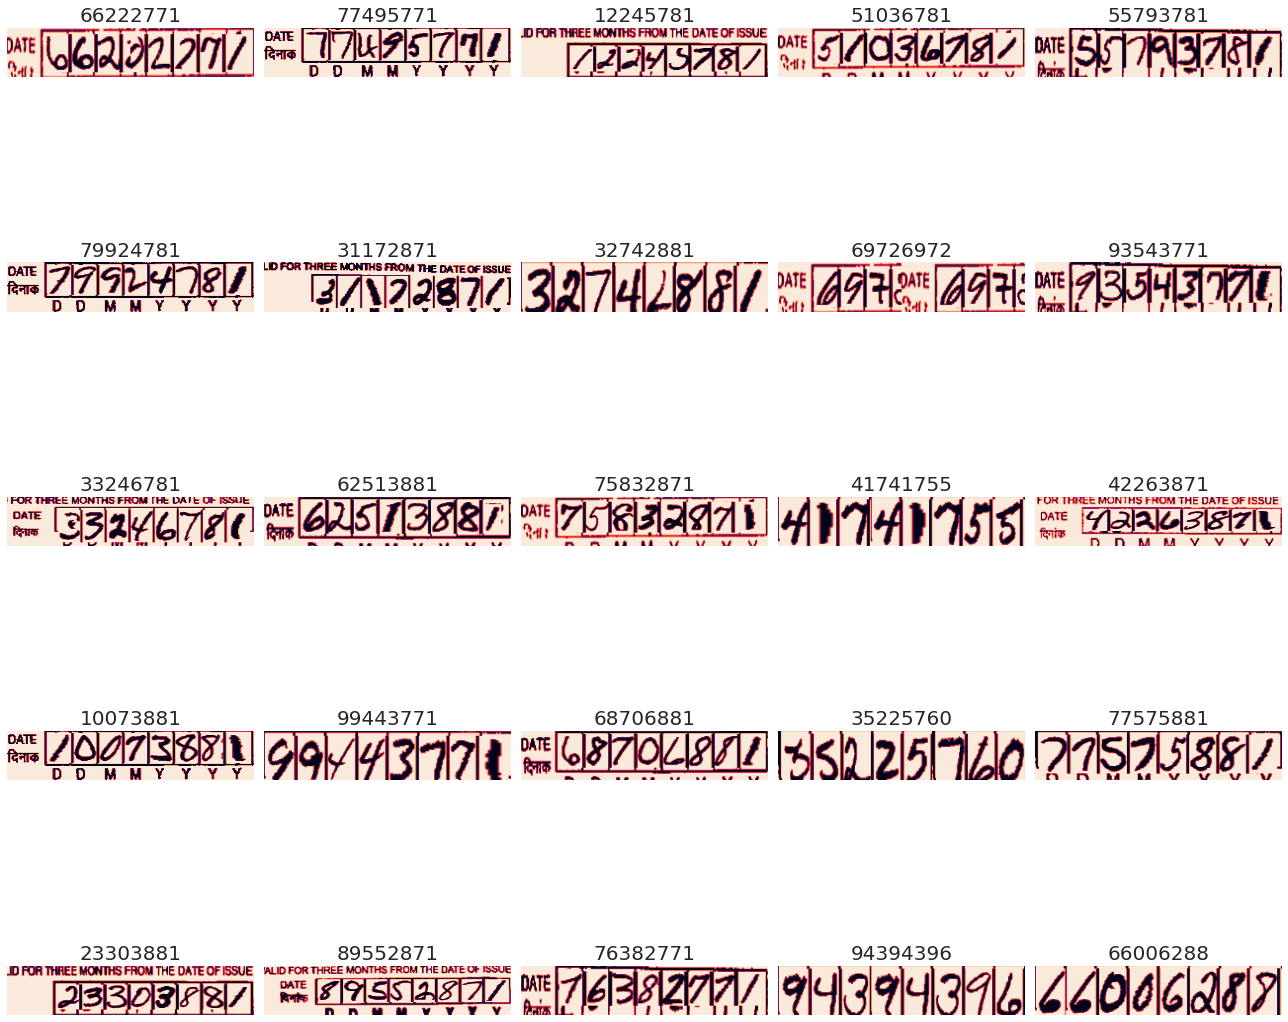

In [38]:
plot_grid(training_data, training_labels)

In [39]:
# Build validation data
validation_data, validation_labels = generate_arrays(df=validation_data)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of validation images:  (2695, 50, 250)
Number of validation labels:  (2695,)


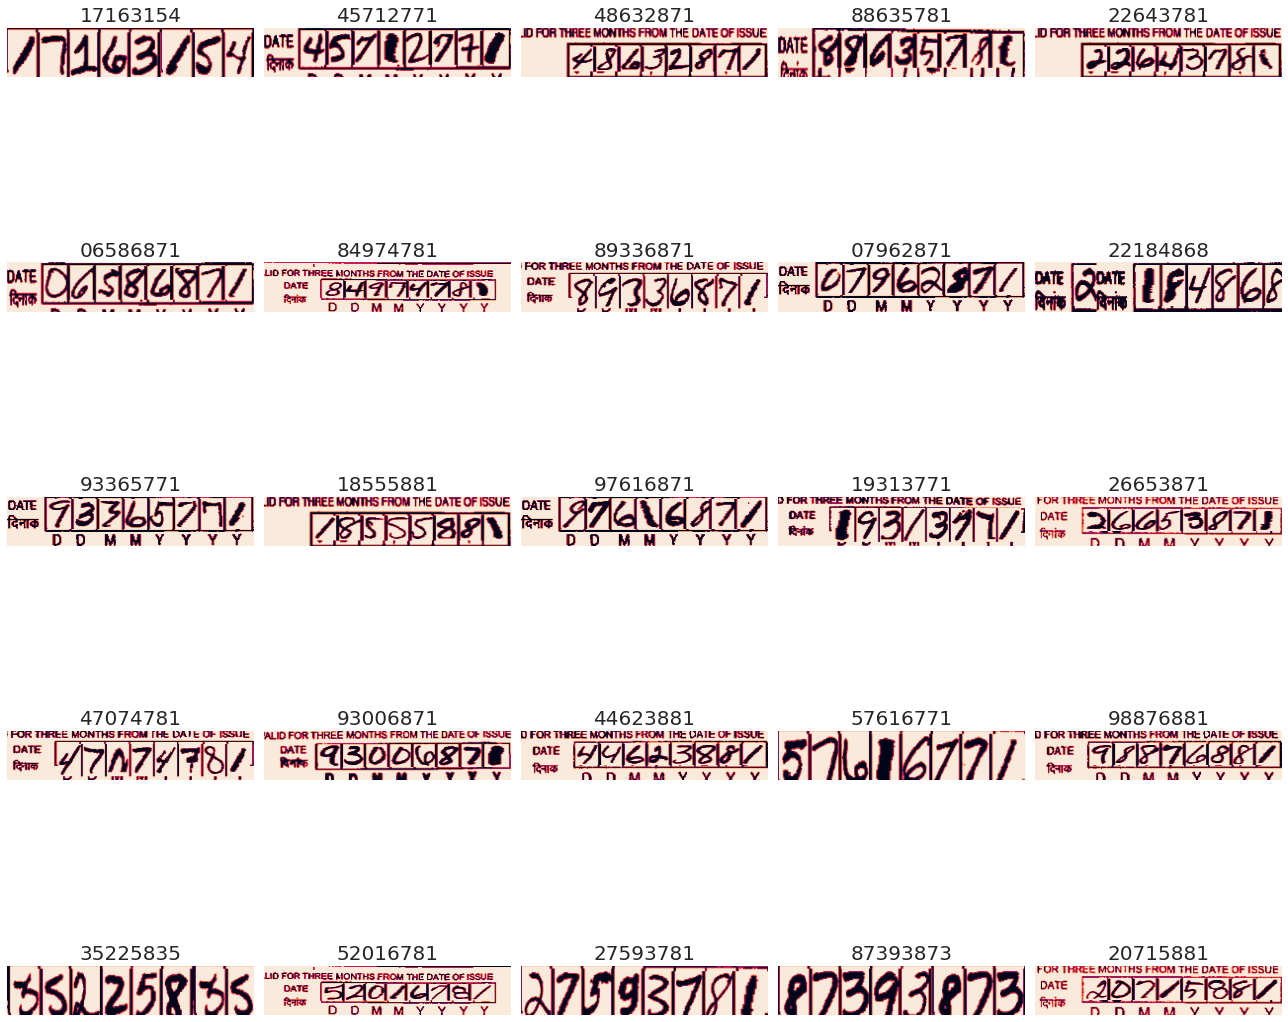

In [40]:
plot_grid(validation_data, validation_labels)

### DataGenerator

In [41]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.

    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs
        batch_labels: a batch of corresponding labels
    """

    def __init__(
        self,
        data,
        labels,
        char_map,
        batch_size=16,
        img_width=250,
        img_height=50,
        downsample_factor=4,
        max_length=5,
        shuffle=True,
    ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]

        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size
        batch_len = len(curr_batch_idx)

        # 3. Instantiate batch arrays
        batch_images = np.ones(
            (batch_len, self.img_width, self.img_height, 1), dtype=np.float32
        )
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * (
            self.img_width // self.downsample_factor - 2
        )
        label_length = np.zeros((batch_len, 1), dtype=np.int64)

        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)

        batch_inputs = {
            "input_data": batch_images,
            "input_label": batch_labels,
            "input_length": input_length,
            "label_length": label_length,
        }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [42]:
batch_size = 16
downsample_factor = 4
epochs = 80
max_length = 8

img_width = 250
img_height = 50

In [43]:
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

In [44]:
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

### Model

In [45]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss

In [46]:
def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1),
                            name='input_data',
                            dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # First conv block
    x = layers.Conv2D(32,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Second conv block
    x = layers.Conv2D(64,
               (3,3),
               activation='relu',
               kernel_initializer='he_normal',
               padding='same',
               name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1,
              activation='softmax', 
              name='dense2',
              kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img,
                                       labels,
                                       input_length,
                                       label_length],
                                outputs=output,
                                name='ocr_model_v1')
    
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model

### Training

In [47]:
model = build_model()

In [48]:
es = keras.callbacks.EarlyStopping(monitor="val_loss",
                                   patience=10,
                                   restore_best_weights=True)

In [49]:
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=epochs,
                    callbacks=[es])

Epoch 1/80
674/674 [==============================] - 188s 279ms/step - loss: 16.7690 - val_loss: 13.9354
Epoch 2/80
674/674 [==============================] - 186s 276ms/step - loss: 8.6949 - val_loss: 2.7485
Epoch 3/80
674/674 [==============================] - 186s 275ms/step - loss: 2.5164 - val_loss: 1.2976
Epoch 4/80
674/674 [==============================] - 187s 277ms/step - loss: 1.5590 - val_loss: 0.9868
Epoch 5/80
674/674 [==============================] - 187s 277ms/step - loss: 1.1738 - val_loss: 0.7666
Epoch 6/80
674/674 [==============================] - 187s 277ms/step - loss: 0.9347 - val_loss: 0.5940
Epoch 7/80
674/674 [==============================] - 186s 276ms/step - loss: 0.7820 - val_loss: 0.6188
Epoch 8/80
674/674 [==============================] - 189s 280ms/step - loss: 0.6891 - val_loss: 0.4914
Epoch 9/80
674/674 [==============================] - 185s 275ms/step - loss: 0.6118 - val_loss: 0.4679
Epoch 10/80
674/674 [==============================] - 189s 28

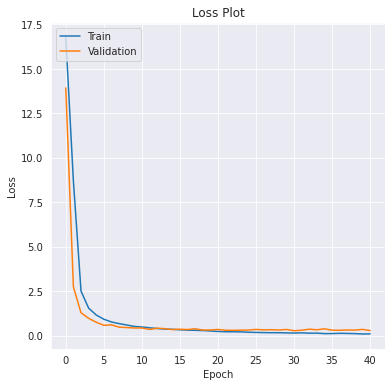

In [50]:
plot_hist(history)

In [51]:
model.save("digits_ocr.h5")

## Evaluation

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [52]:
prediction_model = keras.models.Model(
    model.get_layer(name="input_data").input, model.get_layer(name="dense2").output
)

In [53]:
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    # greedy search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    output_text = []
    for res in results.numpy():
        outstr = ""
        for c in res:
            if c < len(characters) and c >= 0:
                outstr += labels_to_char[c]
        output_text.append(outstr)

    return output_text

### Validation Data Evaluation

**Greedy Evaluation**

In [54]:
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value["input_data"].shape[0]
    X_data = inp_value["input_data"]
    labels = inp_value["input_label"]

    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in labels:
        text = "".join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)

    for i in range(bs):
        print(f"Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}")
    break

Ground truth: 17163154 	 Predicted: 17163154
Ground truth: 45712771 	 Predicted: 45712771
Ground truth: 48632871 	 Predicted: 48632871
Ground truth: 88635781 	 Predicted: 88635781
Ground truth: 22643781 	 Predicted: 22643781
Ground truth: 06586871 	 Predicted: 06586871
Ground truth: 84974781 	 Predicted: 84974781
Ground truth: 89336871 	 Predicted: 89336871
Ground truth: 07962871 	 Predicted: 07962871
Ground truth: 22184868 	 Predicted: 22184868
Ground truth: 93365771 	 Predicted: 93365771
Ground truth: 18555881 	 Predicted: 18555881
Ground truth: 97616871 	 Predicted: 97616871
Ground truth: 19313771 	 Predicted: 19313771
Ground truth: 26653871 	 Predicted: 26653871
Ground truth: 47074781 	 Predicted: 47074781


**Accuracy**

In [55]:
def get_all_preds(data_generator):
    """
    Utility function that returns both model pprediction & actual labels
    """
    decoded_text, actuals_text = [], []
    for p, (inp_value, _) in tqdm(enumerate(data_generator)):
        bs = inp_value["input_data"].shape[0]
        X_data = inp_value["input_data"]
        labels = inp_value["input_label"]

        preds = prediction_model.predict(X_data)
        pred_texts = decode_batch_predictions(preds)

        orig_texts = []
        for label in labels:
            text = "".join([labels_to_char[int(x)] for x in label])
            orig_texts.append(text)

        decoded_text.append([pred_texts[i] for i in range(bs)])
        actuals_text.append([orig_texts[i] for i in range(bs)])

    # flatten 2D list
    decoded_text = list(chain.from_iterable(decoded_text))
    actuals_text = list(chain.from_iterable(actuals_text))
    return decoded_text, actuals_text

In [56]:
decoded_text, actuals_text = get_all_preds(valid_data_generator)

In [57]:
print(f"Validation Data Accuracy: {accuracy_score(actuals_text, decoded_text):.5f}")

Validation Data Accuracy: 0.93395


**PostProcessing** 
* Predicted label length=9 - Remove the last 1

In [58]:
def remove_last_one(label):
    idx = label.rfind("1")
    return label[:idx] + label[idx+1:]

In [59]:
decoded_text = [remove_last_one(x) if len(x)==9 else x for x in decoded_text]

In [60]:
print(f"Validation Data Accuracy (Post Processing): {accuracy_score(actuals_text, decoded_text):.5f}")

Validation Data Accuracy (Post Processing): 0.93395


### Training Data Evaluation

In [61]:
decoded_text, actuals_text = get_all_preds(train_data_generator)

In [62]:
print(f"Training Data Accuracy: {accuracy_score(actuals_text, decoded_text):.5f}")

Training Data Accuracy: 0.98422


In [63]:
decoded_text = [remove_last_one(x) if len(x)==9 else x for x in decoded_text]
print(f"Training Data Accuracy (Post Processing): {accuracy_score(actuals_text, decoded_text):.5f}")

Training Data Accuracy (Post Processing): 0.98422


## Test Data Prediction

In [64]:
test_df = pd.read_csv("raw/test_data/sample_submission.csv")
test_df["img_path"] = test_df["tag"].apply(lambda x: f"processed/test/{x}.png")
test_df["label"] = test_df["label"].astype(str)

In [65]:
# Build testing data
testing_data, testing_labels = generate_arrays(df=test_df)
print(f"# Test Images: {training_data.shape[0]}")

# Test Images: 10776


In [66]:
test_data_generator = DataGenerator(data=testing_data,
                                     labels=testing_labels, # fake labels
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [67]:
decoded_text, _ = get_all_preds(test_data_generator)

In [68]:
decoded_text = [remove_last_one(x) if len(x)==9 else x for x in decoded_text]

In [69]:
len(testing_data), len(decoded_text)

(1000, 1000)

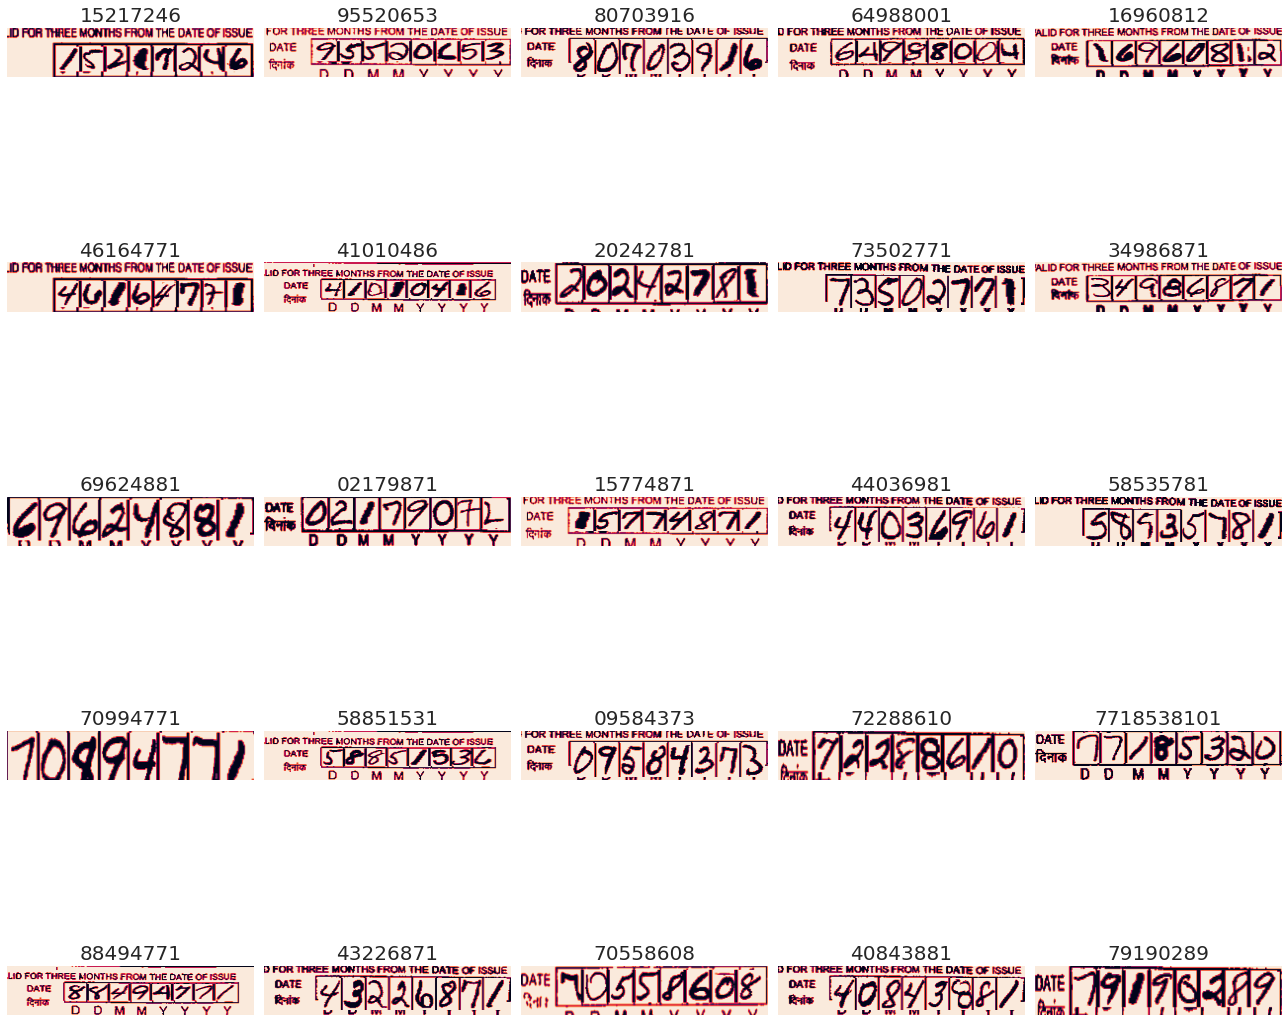

In [70]:
plot_grid(testing_data, decoded_text)

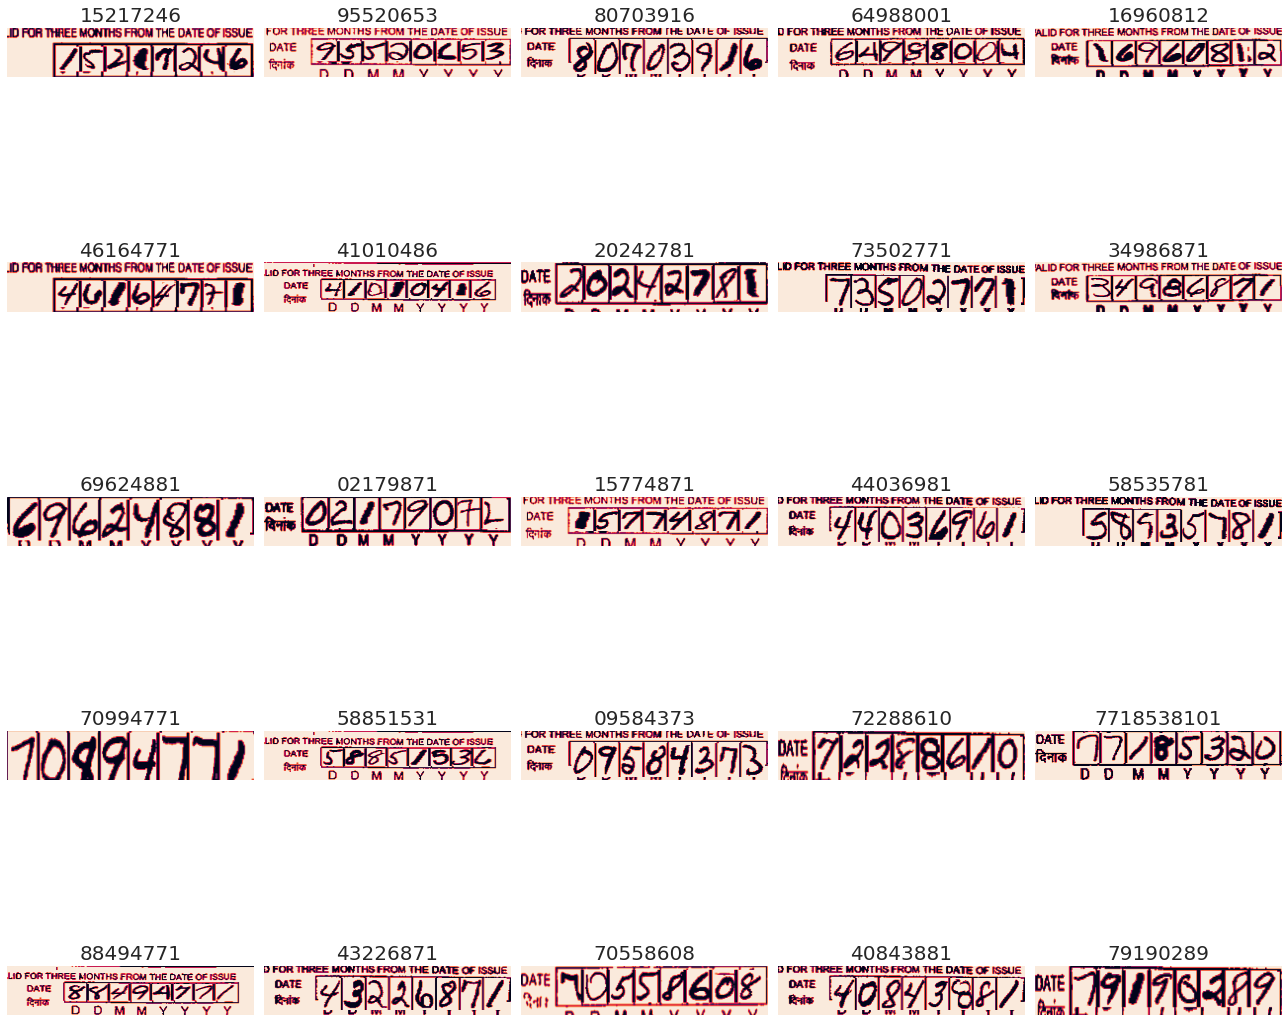

In [71]:
plot_grid(testing_data, decoded_text)

In [72]:
submission = pd.DataFrame()
submission["tag"] = test_df["tag"].tolist()
submission["label"] = decoded_text
submission.to_csv("submission.csv", index=False)

In [73]:
submission.shape

(1000, 2)

In [74]:
submission.head()

,tag,label
0,667,15217246
1,733,95520653
2,530,80703916
3,779,64988001
4,775,16960812


In [75]:
submission["label"].astype(str).str.len().value_counts()

8     946
10     52
11      2
Name: label, dtype: int64

## Submission

In [76]:
sub_json = submission.to_json()
data = {
    "username": "aditya",
    "password": "sdhjbj@8676",
    "submission": sub_json,
    "tag": "digits_v3",
}

In [77]:
r = requests.post(SUBMISSION_URL, json=data)
r.text

'{"success":true,"score":{"acc_8":0.69,"acc_7":0.791,"acc_5":0.92}}'

In [78]:
rl = requests.post(LEADERBOARD_URL, json={})
pprint(rl.json())

{'leaderboard': [{'score_5': 0.918,
                  'score_7': 0.862,
                  'score_8': 0.723,
                  'submitted_at': '2020-11-07-06-41-1604731266',
                  'tag': 'crnn_v1_orig_test2',
                  'username': 'raj'},
                 {'score_5': 0.912,
                  'score_7': 0.868,
                  'score_8': 0.72,
                  'submitted_at': '2020-11-07-08-14-1604736851',
                  'tag': 'crnn_v1_orig_test3',
                  'username': 'raj'},
                 {'score_5': 0.912,
                  'score_7': 0.868,
                  'score_8': 0.72,
                  'submitted_at': '2020-11-07-09-12-1604740378',
                  'tag': 'crnn_v1_orig_test4',
                  'username': 'raj'},
                 {'score_5': 0.946,
                  'score_7': 0.778,
                  'score_8': 0.698,
                  'submitted_at': '2020-11-07-07-48-1604735326',
                  'tag': 'digits_multi_v2',
           

In [79]:
!rm -r raw external processed